In [1]:
import pandas as pd
import pylab as pl
import numpy as np
import scipy.optimize as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
%matplotlib inline 
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Define Combine Simulation

In [2]:
def predict_simu_combine(model_long, 
                         data_simu_x_n_long, 
                         data_simu_y_long, 
                         model_short, 
                         data_simu_x_n_short, 
                         data_simu_y_short, 
                         initial_capital):
    capital = initial_capital
    win_count = 0
    lost_count = 0
    no_order_count = 0
    record_result = []
    record_capital = []
    record_date = []
    consecutive_lost = 0
    consecutive_lost_max = 0
    result_one_one = 0
    for i in range(0, len(data_simu_x_n_short)):
        prediction_long = model_long.predict(data_simu_x_n_long.iloc[i].values.reshape(1,-1))
        prediction_short = model_short.predict(data_simu_x_n_short.iloc[i].values.reshape(1,-1))
        
        # if prediction_long ==1 and prediction_short == 1
        #     no trade
        # if prediction_long == 1 and prediction_short ==0
        #     trade long
        # if prediction_long ==0 and prediction_short == 1
        #     trade short
        # if prediction_long == 0 and prediction_short ==0
        #     no trade
        if prediction_long ==1 and prediction_short == 1:
            no_order_count +=1
            order_record = 'no order--- p_long = {0}, p_short = {1},  actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'None')
            capital = capital
            result = 'no order'
            result_one_one += 1
        elif prediction_long == 1 and prediction_short == 0 and data_simu_y_long[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'win'
        elif prediction_long == 1 and prediction_short == 0 and data_simu_y_long[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'lost'
        elif prediction_long == 0 and prediction_short == 1 and data_simu_y_short[i] == 1:
            outcome = 3
            capital += outcome
            win_count += 1
            order_record = 'win-------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'win'
        elif prediction_long == 0 and prediction_short == 1 and data_simu_y_short[i] == 0:
            outcome = -3.3
            capital += outcome
            lost_count += 1
            order_record = 'lost------- p_long = {0},p_short = {1}, actual = {2}, model = {3}'.format(prediction_long, prediction_short,data_simu_y_long[i],'Long')
            result = 'lost'
        elif prediction_long == 0 and prediction_short == 0:
            no_order_count +=1
            order_record = 'no order--- p_long = {0}, p_short = {1},  actual = {2}, model = {3}'.format(prediction_long, prediction_short, data_simu_y_long[i],'None')
            capital = capital
            result = 'no order'
        else:
            raise ValueError('no condition met')
        record_date.append(data_simu_x_n_long.iloc[i].name)
        record_result.append(order_record)
        record_capital.append(capital)

        #Calculate Consecutive Lost
        if result == 'lost':
            consecutive_lost += -3.3
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
        if result == 'win':
            if consecutive_lost <= consecutive_lost_max:
                consecutive_lost_max = consecutive_lost
            consecutive_lost = 0

    total_return = ((capital - initial_capital) / initial_capital)*100
    sim_df = pd.DataFrame({'record_date':record_date,
                           'record_result':record_result,
                           'record_capital': record_capital})
    sim_df.set_index('record_date', inplace=True)

    return win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max, result_one_one


Total Return: 88.0%
Final Capital: $940.0
Win Count:  182
Lost Count:  32
No Order Count:  12284
Max Consecutive Lost: 2.0 trades
Total day on trading: 67 days
result one one 4
Accuracy0.85%


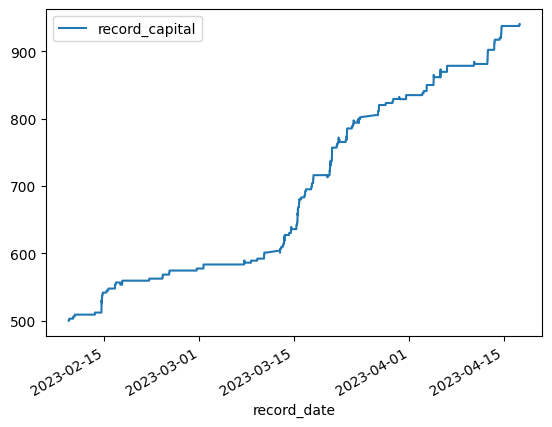

In [4]:
import pickle

lsvm_long = pickle.load(open('lsvm_xauusd_long_c.pkl','rb'))
y_test_long = np.loadtxt('y_long_simu_c.csv', delimiter=',')
X_test_simu_n_long = pd.read_csv('X_long_simu_c.csv',index_col='date', parse_dates=True)

lsvm_short = pickle.load(open('lsvm_xauusd_short_c.pkl','rb'))
y_test_short = np.loadtxt('y_short_simu_c.csv', delimiter=',')
X_test_simu_n_short = pd.read_csv('X_short_simu_c.csv',index_col='date', parse_dates=True)

win_count, lost_count, no_order_count, capital, total_return, sim_df, consecutive_lost_max, result_one_one = predict_simu_combine(lsvm_long, X_test_simu_n_long, y_test_long, lsvm_short, X_test_simu_n_short, y_test_short, 500)                                                          
print('Total Return: {0}%'.format(round(total_return,0)))
print('Final Capital: ${0}'.format(round(capital,0)))
print('Win Count: ',win_count)
print('Lost Count: ',lost_count)
print('No Order Count: ', no_order_count)
print('Max Consecutive Lost: {0} trades'.format(consecutive_lost_max/-3.3))
day_one = X_test_simu_n_short.iloc[0].name.to_pydatetime().date()
day_final = X_test_simu_n_short.iloc[len(X_test_simu_n_short)-1].name.to_pydatetime().date()
print('Total day on trading: {0} days'.format((day_final - day_one).days))
print('result one one',result_one_one)
sim_df.plot(y='record_capital')
Accuracy = win_count /(win_count+lost_count)
print(f"Accuracy {Accuracy:.2f}%")